In [4]:
# import packages for doing time series classification form .csv files
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.utils.class_weight import compute_class_weight
from sklearn.ensemble import RandomForestClassifier


import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
from torch.utils.data import DataLoader, TensorDataset, Dataset
from tqdm import tqdm

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [5]:
train_set = pd.read_csv("project2_TS_input/mitbih_train.csv", header=None)
test_set = pd.read_csv("project2_TS_input/mitbih_test.csv", header=None)

train_set_ptb = pd.read_csv("project2_TS_input/ptbdb_train.csv", header=None)
test_set_ptb = pd.read_csv("project2_TS_input/ptbdb_test.csv", header=None)

In [6]:
y_train=train_set.iloc[:,-1]
X_train = train_set.iloc[:,:-1]
y_test=test_set.iloc[:,-1]
X_test = test_set.iloc[:,:-1]


y_train_ptb=train_set_ptb.iloc[:,-1]
X_train_ptb = train_set_ptb.iloc[:,:-1]
y_test_ptb=test_set_ptb.iloc[:,-1]
X_test_ptb = test_set_ptb.iloc[:,:-1]

In [7]:
X_train.head()

,0,1,2,3,4,5,6,7,8,9,...,177,178,179,180,181,182,183,184,185,186
0,0.977941,0.926471,0.681373,0.245098,0.154412,0.191176,0.151961,0.085784,0.058824,0.049020,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.960114,0.863248,0.461538,0.196581,0.094017,0.125356,0.099715,0.088319,0.074074,0.082621,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.000000,0.659459,0.186486,0.070270,0.070270,0.059459,0.056757,0.043243,0.054054,0.045946,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.925414,0.665746,0.541436,0.276243,0.196133,0.077348,0.071823,0.060773,0.066298,0.058011,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.967136,1.000000,0.830986,0.586854,0.356808,0.248826,0.145540,0.089202,0.117371,0.150235,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# MIT dataset exploration

<Axes: >

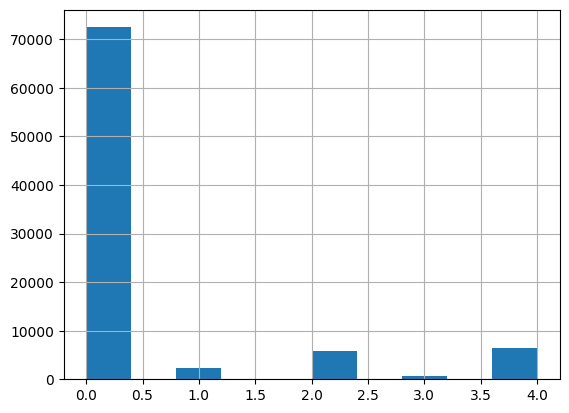

In [8]:
y_train.hist()

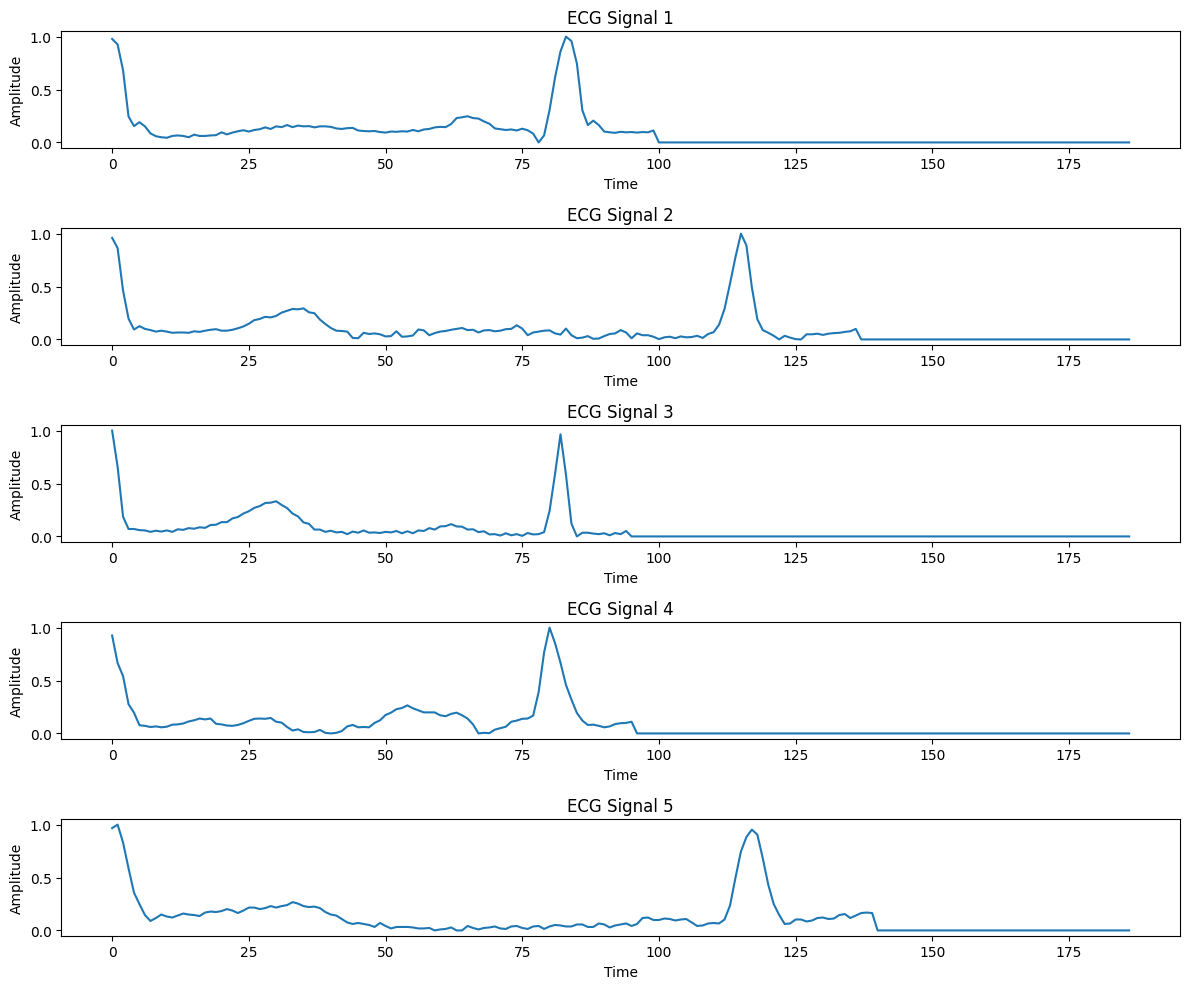

In [9]:
fig, axs = plt.subplots(5, figsize=(12, 10))

# Iterate through the first 5 ECG signals
for i in range(5):
    # Plot the ECG signal on the corresponding subplot
    axs[i].plot(X_train.iloc[i,:])

    # Add title and labels for each subplot
    axs[i].set_title(f'ECG Signal {i + 1}')
    axs[i].set_xlabel('Time')
    axs[i].set_ylabel('Amplitude')

# Adjust the layout and show the plot
plt.tight_layout()
plt.show()

In [10]:
X_test.shape

(21892, 187)

In [19]:
X_train_tensor = torch.tensor(X_train.values , dtype=torch.float)
y_train_tensor= torch.tensor(y_train, dtype=torch.float32).view(-1, 1)

X_test_tensor = torch.tensor(X_test.values , dtype=torch.float)
y_test_tensor= torch.tensor(y_test, dtype=torch.float32).view(-1, 1)

# Create a DataLoader for each dataset
batch_size = 128
loader_train = DataLoader(torch.utils.data.TensorDataset(X_train_tensor, y_train_tensor), batch_size=batch_size, shuffle=True)
loader_test = DataLoader(torch.utils.data.TensorDataset(X_test_tensor, y_test_tensor), batch_size=X_test.shape[0], shuffle=False)
loader_valid = DataLoader(torch.utils.data.TensorDataset(X_test_tensor, y_test_tensor), batch_size=X_test.shape[0], shuffle=False)

X_train_tensor_ptb = torch.tensor(X_train_ptb.values , dtype=torch.float)
y_train_tensor_ptb = torch.tensor(y_train_ptb, dtype=torch.float32).view(-1, 1)

X_test_tensor_ptb = torch.tensor(X_test_ptb.values , dtype=torch.float)
y_test_tensor_ptb = torch.tensor(y_test_ptb, dtype=torch.float32).view(-1, 1)

# Create a DataLoader for each dataset
batch_size = 128
loader_train_ptb = DataLoader(torch.utils.data.TensorDataset(X_train_tensor_ptb, y_train_tensor_ptb), batch_size=batch_size, shuffle=True)
loader_test_ptb = DataLoader(torch.utils.data.TensorDataset(X_test_tensor_ptb, y_test_tensor_ptb), batch_size=X_test_tensor_ptb.shape[0], shuffle=False)
loader_valid_ptb = DataLoader(torch.utils.data.TensorDataset(X_test_tensor_ptb, y_test_tensor_ptb), batch_size=X_test_tensor_ptb.shape[0], shuffle=False)

In [12]:
X_train_tensor.shape

torch.Size([87554, 187])

In [13]:
def calculate_class_weights(y_train):
    # Ensure y_train is a numpy array if it's a torch tensor
    if isinstance(y_train, torch.Tensor):
        y_train = y_train.numpy()
    
    # Flatten y_train to ensure it's one-dimensional
    if y_train.ndim > 1:
        y_train = y_train.flatten()
    
    # Calculate class weights inversely proportional to class frequencies
    class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
    class_weights_tensor = torch.tensor(class_weights, dtype=torch.float)
    
    return class_weights_tensor

# Example usage, assuming y_train_tensor is your tensor of training labels
# Convert it to one-dimensional if necessary before using it:
class_weights = calculate_class_weights(y_train_tensor)
print("Class weights tensor: ", class_weights)

Class weights tensor:  tensor([ 0.2416,  7.8771,  3.0254, 27.3179,  2.7229])


# Q1: Supervised Model for Transfer

In [14]:
class CNN(nn.Module):
    def __init__(self,classes):
        super(CNN, self).__init__()

        self.convolutions = nn.Sequential( # downsampling factor = 4
                            # First conv layer to increase channel depth
                            nn.Conv1d(1, 64, kernel_size=5, stride=1, padding=2, bias=False),
                            nn.BatchNorm1d(64),
                            nn.ReLU(inplace=True),
                            # Second conv layer to downsample
                            nn.Conv1d(64, 64, kernel_size=5, stride=4, padding=1, bias=False),
                            nn.BatchNorm1d(64),
                            nn.ReLU(inplace=True),
        )
        self.fc2 = nn.Linear(64*47, classes)

    def forward(self, x):
        x = x.unsqueeze(1)
        representation = self.convolutions(x)
        flattened= torch.flatten(representation, 1)
        class_scores = self.fc2(flattened)
        return representation, class_scores
    
    def predict(self, x):
        x = x.unsqueeze(1)
        representation = self.convolutions(x)
        return representation 

In [34]:
# Check for GPU availability
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model_pretrained_mit = CNN(5).to(device)

# Define the loss function and the optimizer
criterion = nn.CrossEntropyLoss() #weight=class_weights)
optimizer = optim.Adam(model_pretrained_mit.parameters(), lr=0.001)

In [35]:
model_pretrained_mit_balanced = CNN(5).to(device)

# Define the loss function and the optimizer
criterion_balanced = nn.CrossEntropyLoss(weight=class_weights)
optimizer_balanced = optim.Adam(model_pretrained_mit_balanced.parameters(), lr=0.001)

In [30]:
# train the model
def train(model, criterion, optimizer, train_loader, epochs=5, plot = True):
    '''
    Train the network and validate it at each epoch plotting the training and validation loss curves
    '''
    train_losses = []
    valid_losses = []


    for epoch in range(epochs):
        model.train()
        train_loss = 0.0

        for timeseries, labels in tqdm(train_loader):
            timeseries, labels = timeseries.to(device), labels.to(device)
            optimizer.zero_grad()
            representation, output = model(timeseries)
            probabilities = torch.softmax(output, dim=1)
            _, predicted_classes = torch.max(probabilities, 1)
            loss = criterion(output, labels.squeeze().long())
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        train_loss /= len(train_loader)
        train_losses.append(train_loss)

        print(f"Epoch {epoch + 1}/{epochs}.. "
              f"Train loss: {train_loss:.3f}")

    if plot:
        plt.plot(train_losses, label='Training loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()
        plt.show()

    return train_losses

100%|██████████| 685/685 [00:53<00:00, 12.91it/s]


Epoch 1/10.. Train loss: 0.169


100%|██████████| 685/685 [00:53<00:00, 12.76it/s]


Epoch 2/10.. Train loss: 0.108


100%|██████████| 685/685 [00:53<00:00, 12.89it/s]


Epoch 3/10.. Train loss: 0.095


100%|██████████| 685/685 [00:54<00:00, 12.60it/s]


Epoch 4/10.. Train loss: 0.084


100%|██████████| 685/685 [00:53<00:00, 12.80it/s]


Epoch 5/10.. Train loss: 0.078


100%|██████████| 685/685 [00:52<00:00, 12.93it/s]


Epoch 6/10.. Train loss: 0.073


100%|██████████| 685/685 [00:52<00:00, 12.93it/s]


Epoch 7/10.. Train loss: 0.068


100%|██████████| 685/685 [00:53<00:00, 12.70it/s]


Epoch 8/10.. Train loss: 0.064


100%|██████████| 685/685 [01:09<00:00,  9.80it/s]


Epoch 9/10.. Train loss: 0.061


100%|██████████| 685/685 [01:04<00:00, 10.64it/s]


Epoch 10/10.. Train loss: 0.057


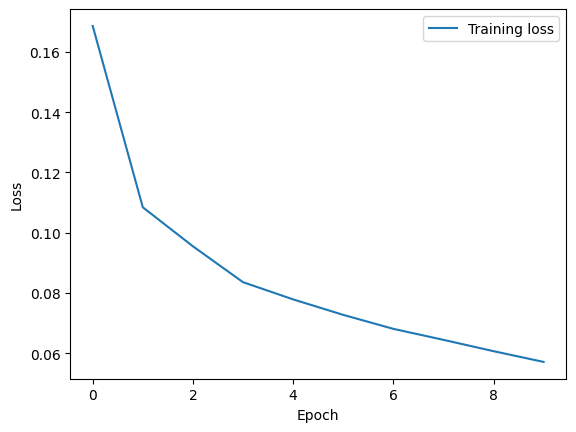

In [36]:
train_losses= train(model_pretrained_mit, criterion, optimizer, loader_train, epochs=10)

In [37]:
# Evaluate the model on the test set

def evaluate(model, test_loader):
    '''
    Evaluate the model on the test set
    '''
    model.eval()
    test_loss = 0.0
    correct = 0

    with torch.no_grad():
        for timeseries, labels in test_loader:
            
            timeseries, labels = timeseries.to(device), labels.to(device)
            representation, output = model(timeseries)
            labels = labels.float()
            
            probabilities = torch.softmax(output, dim=1)
            _, predicted_classes = torch.max(probabilities, 1)
 
            cm = ConfusionMatrixDisplay.from_predictions(labels, predicted_classes.numpy(), #display_labels=['Class 0', 'Class 1'], 
                                                    cmap='Blues', 
                                                    normalize=None)

            print(classification_report(labels.numpy(), predicted_classes.numpy()))
            print("F1: ",f1_score(labels.numpy(), predicted_classes.numpy(), average='macro'))

    
    
    return predicted_classes




torch.Size([21892, 187])
torch.Size([21892, 5])
              precision    recall  f1-score   support

         0.0       0.99      0.99      0.99     18118
         1.0       0.79      0.71      0.75       556
         2.0       0.95      0.93      0.94      1448
         3.0       0.77      0.77      0.77       162
         4.0       0.99      0.98      0.98      1608

    accuracy                           0.98     21892
   macro avg       0.90      0.88      0.89     21892
weighted avg       0.98      0.98      0.98     21892

F1:  0.8862849710095224


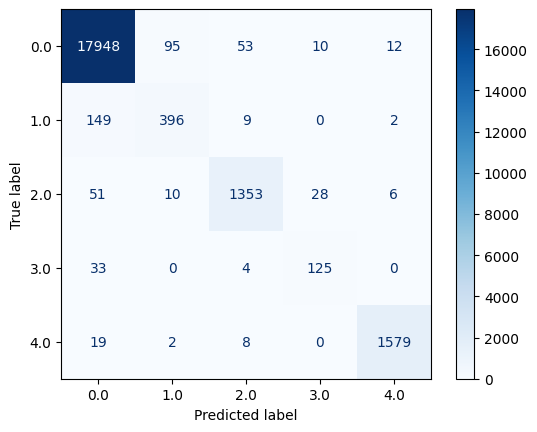

In [38]:
predicted_classes = evaluate(model_pretrained_mit, loader_test)

In [86]:
save_model = {
    'state_dict': model_pretrained_mit.state_dict(),
    'optimizer': optimizer.state_dict()
}

torch.save(save_model, 'Model_pretrained_mit_CNN.pth')

# Q3: Visualising Learned Representations

In [26]:
device = torch.device('mps')
def return_representations(model, data_loader):
    model.eval()
    embeddings = []
    labels = []
    with torch.no_grad():
        for timeseries, targets in tqdm(data_loader):
            timeseries, targets = timeseries.to(device), targets.to(device)
            embedding, output = model(timeseries)
            #print(embedding.shape)
            embeddings.append(embedding.detach().cpu().numpy())
            labels.append(targets.detach().cpu().numpy())
    embeddings = np.concatenate(embeddings, axis=0)
    labels = np.concatenate(labels, axis=0)
    return embeddings, labels

In [27]:
from sklearn.manifold import TSNE

def plot_embeddings(embeddings, labels):
    n_samples, channels, length = embeddings.shape
    embeddings_flat = embeddings.reshape(n_samples, -1)  # Flatten to (n_samples, channels * length)
    tsne = TSNE(n_components=2, random_state=42, perplexity=40)
    print(embeddings_flat.shape)
    embeddings_2d = tsne.fit_transform(embeddings_flat)
    
    plt.figure(figsize=(10, 10))
    scatter = plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], c=labels, cmap='viridis')
    plt.colorbar(scatter, ticks=np.unique(labels))
    plt.show()

In [28]:

##Load the pretained model on mit dataset from the checkpoint
device = torch.device('mps')
model_pretrained_mit = CNN(5).to(device)
PATH = 'project2_TS_output/Model_pretrained_mit_CNN.pth'

# Load the checkpoint
checkpoint = torch.load(PATH)

# Extract the state_dict from the loaded checkpoint
state_dict = checkpoint['state_dict']

# Load the state_dict into your model
model_pretrained_mit.load_state_dict(state_dict)

# Move your model to the appropriate device (e.g., GPU or CPU)
model_pretrained_mit.to(device)

CNN(
  (convolutions): Sequential(
    (0): Conv1d(1, 64, kernel_size=(5,), stride=(1,), padding=(2,), bias=False)
    (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv1d(64, 64, kernel_size=(5,), stride=(4,), padding=(1,), bias=False)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
  )
  (fc2): Linear(in_features=3008, out_features=5, bias=True)
)

In [29]:
mit_train_embeddings, mit_train_labels=return_representations(model_pretrained_mit, loader_train)
mit_test_embeddings, mit_test_labels=return_representations(model_pretrained_mit, loader_test)
ptb_train_embeddings, ptb_train_labels=return_representations(model_pretrained_mit, loader_train_ptb)
ptb_test_embeddings, ptb_test_labels=return_representations(model_pretrained_mit, loader_test_ptb)

100%|██████████| 1/1 [00:00<00:00, 55.27it/s]


In [31]:
print("MIT train embeddings shape: ", mit_train_embeddings.shape)

MIT train embeddings shape:  (87554, 64, 47)


(87554, 3008)


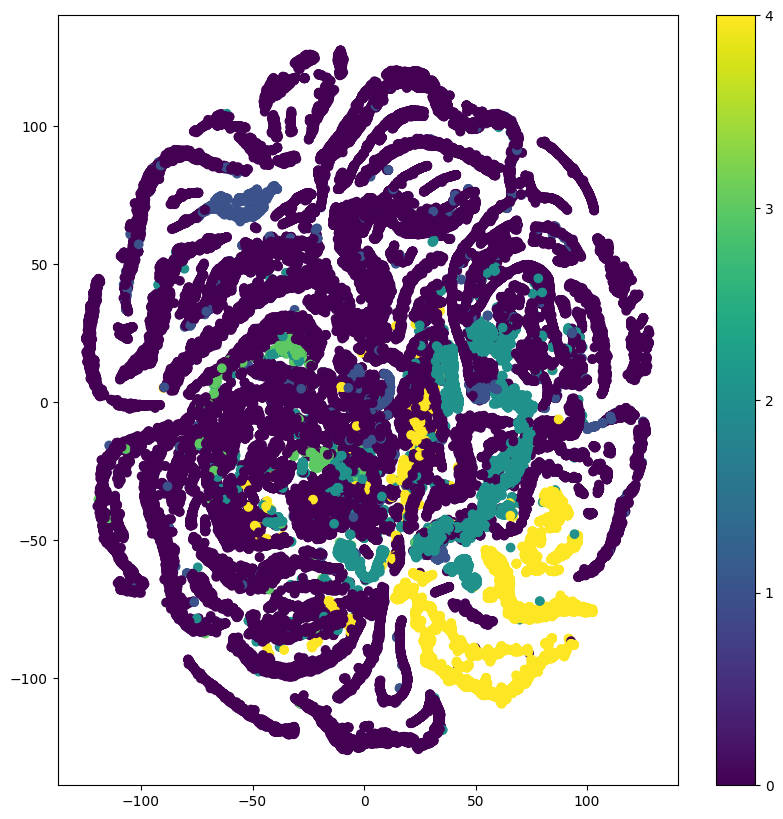

In [30]:
plot_embeddings(mit_train_embeddings, mit_train_labels)

(21892, 3008)


/usr/local/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


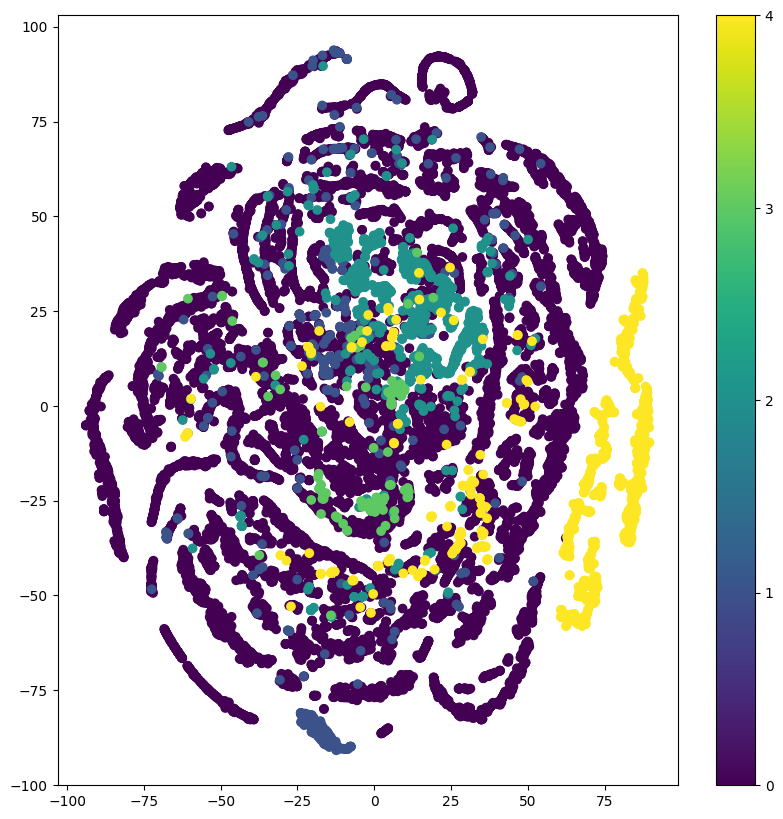

In [50]:
plot_embeddings(mit_test_embeddings, mit_test_labels)

(11641, 3008)


/usr/local/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


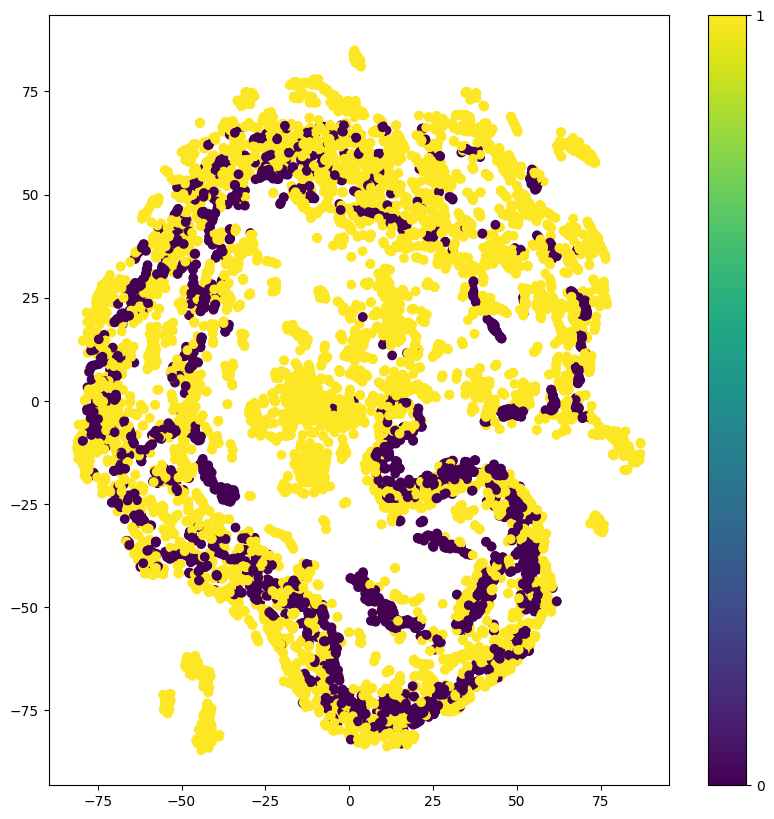

In [81]:
plot_embeddings(ptb_train_embeddings, ptb_train_labels)

(2911, 3008)


/usr/local/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


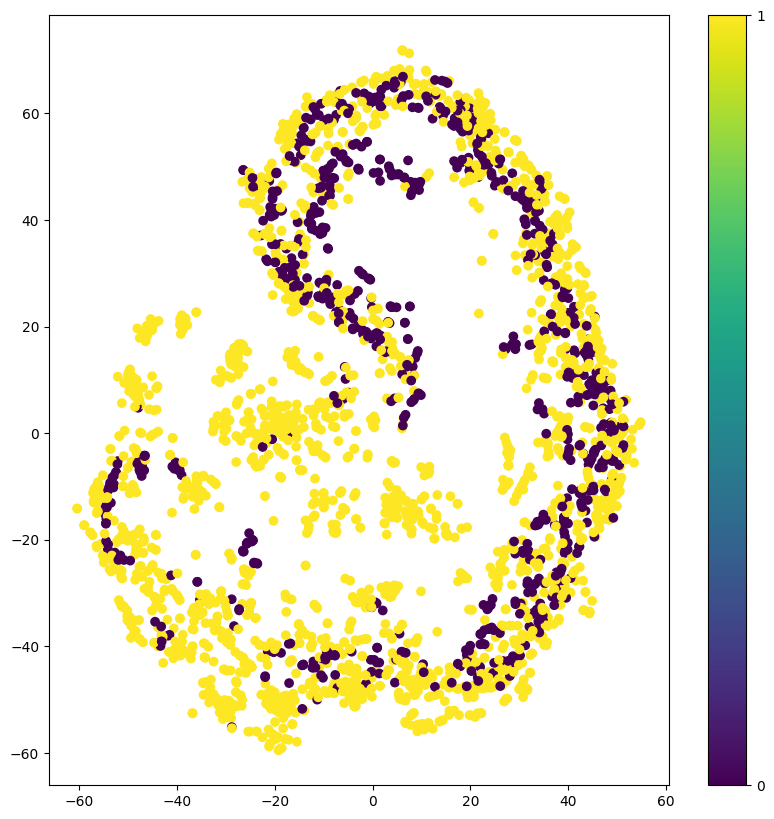

In [52]:
plot_embeddings(ptb_test_embeddings, ptb_test_labels)

# Q4: Finetuning Strategies (9 Pts)

## 1. Classic ML method

/var/folders/jj/m28xy22x5w74b624rj27hpn80000gn/T/ipykernel_965/314521866.py:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf.fit(ptb_train_embeddings.reshape(ptb_train_embeddings.shape[0], -1), ptb_train_labels)


              precision    recall  f1-score   support

         0.0       0.98      0.93      0.96       809
         1.0       0.97      0.99      0.98      2102

    accuracy                           0.98      2911
   macro avg       0.98      0.96      0.97      2911
weighted avg       0.98      0.98      0.98      2911

F1:  0.983529411764706
Accuracy: 0.9760


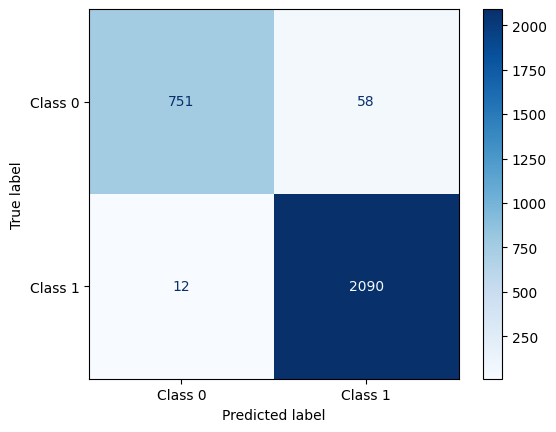

In [55]:
rf = RandomForestClassifier(random_state=42)

rf.fit(ptb_train_embeddings.reshape(ptb_train_embeddings.shape[0], -1), ptb_train_labels)
    
y_pred = rf.predict(ptb_test_embeddings.reshape(ptb_test_embeddings.shape[0], -1))

cm = ConfusionMatrixDisplay.from_predictions(ptb_test_labels, y_pred, 
                                            display_labels=['Class 0', 'Class 1'], 
                                            cmap='Blues', 
                                            normalize=None)
 
print(classification_report(ptb_test_labels, y_pred))
print("F1: ",f1_score(ptb_test_labels, y_pred))
print(f'Accuracy: {accuracy_score(ptb_test_labels, y_pred):.4f}')

# 2. MLP output layers  

### Training the output layer(s) only

freeze encoder layers, add a binary classification layer to finetune on ptb dataset

In [58]:
from copy import deepcopy
# Copy the pretrained model
model_A_CNN = deepcopy(model_pretrained_mit)

# Modify the copied model
model_A_CNN.fc2 = nn.Linear(64 * 47, 1)  # Change output layer to binary classification (1 output unit)

# Freeze the convolutional layers
for param in model_A_CNN.convolutions.parameters():
    param.requires_grad = False

In [78]:
def train_ptb(model,optimizer,criterion):
    train_losses = []
    epochs=10

    for epoch in range(epochs):
        model.train()
        train_loss = 0.0

        for timeseries, labels in tqdm(loader_train_ptb):
            timeseries, labels = timeseries.to(device), labels.to(device)
            optimizer.zero_grad()
            representation, output = model(timeseries)
            probabilities = torch.softmax(output, dim=1)
            _, predicted_classes = torch.max(probabilities, 1)
            loss = criterion(output, labels)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        train_loss /= len(loader_train_ptb)
        train_losses.append(train_loss)

        print(f"Epoch {epoch + 1}/{epochs}.. "
                f"Train loss: {train_loss:.3f}")


    plt.plot(train_losses, label='Training loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

100%|██████████| 91/91 [00:03<00:00, 27.86it/s]


Epoch 1/10.. Train loss: 0.282


100%|██████████| 91/91 [00:02<00:00, 33.47it/s]


Epoch 2/10.. Train loss: 0.211


100%|██████████| 91/91 [00:03<00:00, 28.52it/s]


Epoch 3/10.. Train loss: 0.181


100%|██████████| 91/91 [00:03<00:00, 28.44it/s]


Epoch 4/10.. Train loss: 0.161


100%|██████████| 91/91 [00:04<00:00, 19.61it/s]


Epoch 5/10.. Train loss: 0.147


100%|██████████| 91/91 [00:06<00:00, 15.05it/s]


Epoch 6/10.. Train loss: 0.137


100%|██████████| 91/91 [00:04<00:00, 18.80it/s]


Epoch 7/10.. Train loss: 0.128


100%|██████████| 91/91 [00:05<00:00, 18.08it/s]


Epoch 8/10.. Train loss: 0.121


100%|██████████| 91/91 [00:03<00:00, 22.77it/s]


Epoch 9/10.. Train loss: 0.116


100%|██████████| 91/91 [00:02<00:00, 34.24it/s]


Epoch 10/10.. Train loss: 0.110


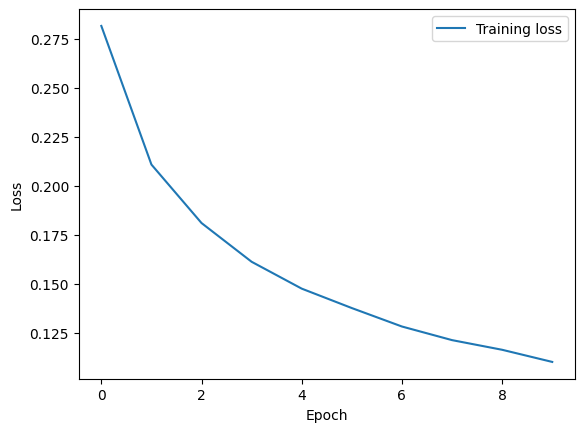

In [64]:
optimizer_A = optim.Adam(model_A_CNN.fc2.parameters(), lr=0.001)
criterion = nn.BCEWithLogitsLoss()  # Binary classification for PTB dataset

train_ptb(model_A_CNN,optimizer_A,criterion)

In [72]:
def evaluate_ptb(model, test_loader,criterion):
    '''
    Evaluate the model on the test set
    '''
    model.eval()
    test_loss = 0.0
    correct = 0

    with torch.no_grad():
        for timeseries, labels in test_loader:
            timeseries, labels = timeseries.to(device), labels.to(device)
            repr, output = model(timeseries)
            labels = labels.float()
            #print(labels.shape)
            loss = criterion(output, labels)
            test_loss += loss.item()
            preds = torch.round(torch.sigmoid(output))
            correct += (preds == labels).sum().item()
            
            test_loss /= len(test_loader)
            accuracy = correct / len(test_loader.dataset)

            print(f"Test loss: {test_loss:.3f}.. "
                  f"Test accuracy: {accuracy:.3f}")

            cm = ConfusionMatrixDisplay.from_predictions(labels, preds.numpy(), 
                                                    display_labels=['Class 0', 'Class 1'], 
                                                    cmap='Blues', 
                                                    normalize=None)

            print(classification_report(labels, preds.numpy()))
            print("F1: ",f1_score(labels, preds.numpy()))

    
    
    return test_loss, accuracy

Test loss: 0.129.. Test accuracy: 0.959
              precision    recall  f1-score   support

         0.0       0.94      0.92      0.93       809
         1.0       0.97      0.98      0.97      2102

    accuracy                           0.96      2911
   macro avg       0.95      0.95      0.95      2911
weighted avg       0.96      0.96      0.96      2911

F1:  0.9720511605873994


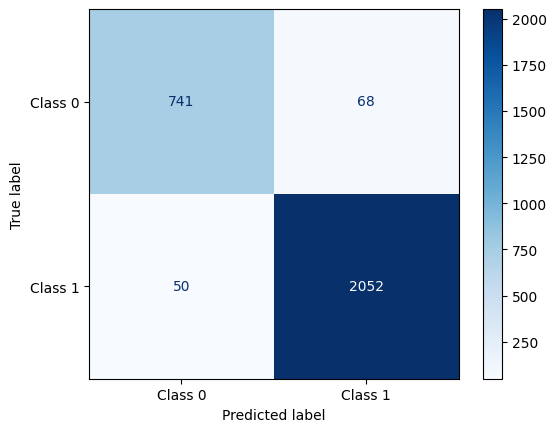

In [73]:
test_loss, accuracy = evaluate_ptb(model_A_CNN, loader_test_ptb, nn.BCEWithLogitsLoss())

In [85]:
save_model = {
    'state_dict': model_A_CNN.state_dict(),
    'optimizer': optimizer_A.state_dict()
}

torch.save(save_model, 'Model_A_CNN.pth')

### B. Train the entire model on the PTB dataset(encoder+outputlayers)

build a new CNN with output dimension 1 in the last layer, train and test on PTB : 

In [74]:
model_B_CNN = CNN(1).to(device)

100%|██████████| 91/91 [00:10<00:00,  8.81it/s]


Epoch 1/10.. Train loss: 0.380


100%|██████████| 91/91 [00:10<00:00,  8.56it/s]


Epoch 2/10.. Train loss: 0.261


100%|██████████| 91/91 [00:11<00:00,  7.92it/s]


Epoch 3/10.. Train loss: 0.197


100%|██████████| 91/91 [00:07<00:00, 12.61it/s]


Epoch 4/10.. Train loss: 0.168


100%|██████████| 91/91 [00:07<00:00, 12.56it/s]


Epoch 5/10.. Train loss: 0.141


100%|██████████| 91/91 [00:07<00:00, 12.92it/s]


Epoch 6/10.. Train loss: 0.130


100%|██████████| 91/91 [00:06<00:00, 13.17it/s]


Epoch 7/10.. Train loss: 0.115


100%|██████████| 91/91 [00:07<00:00, 12.68it/s]


Epoch 8/10.. Train loss: 0.100


100%|██████████| 91/91 [00:07<00:00, 12.17it/s]


Epoch 9/10.. Train loss: 0.093


100%|██████████| 91/91 [00:06<00:00, 13.02it/s]


Epoch 10/10.. Train loss: 0.083


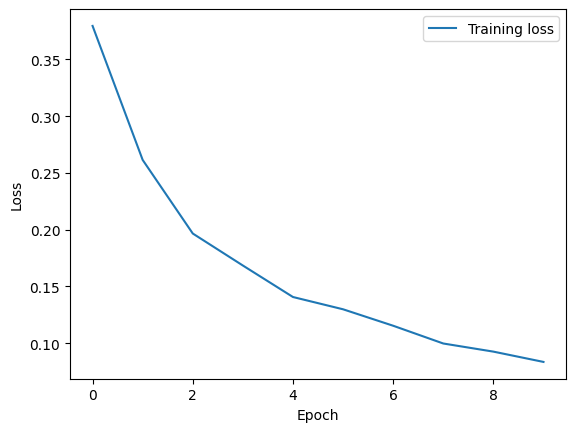

In [75]:
# Define the loss function and the optimizer
optimizer_B = optim.Adam(model_B_CNN.parameters(), lr=0.001)
criterion_B = nn.BCEWithLogitsLoss()  # Binary classification for PTB dataset

train_ptb(model_B_CNN,optimizer_B,criterion_B)

Test loss: 0.111.. Test accuracy: 0.964
              precision    recall  f1-score   support

         0.0       0.94      0.93      0.94       809
         1.0       0.97      0.98      0.98      2102

    accuracy                           0.96      2911
   macro avg       0.96      0.95      0.96      2911
weighted avg       0.96      0.96      0.96      2911

F1:  0.9753203607024205


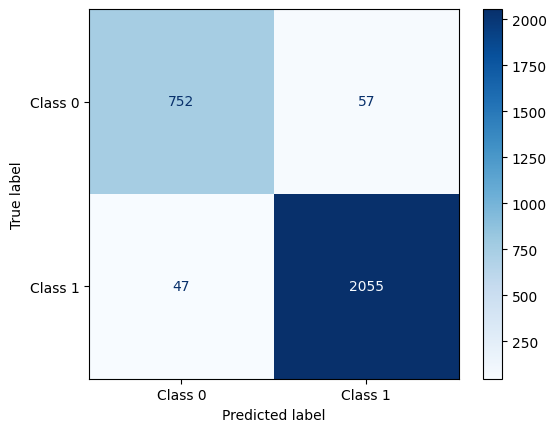

In [76]:
test_loss, accuracy = evaluate_ptb(model_B_CNN, loader_test_ptb, nn.BCEWithLogitsLoss())

In [84]:
save_model = {
    'state_dict': model_B_CNN.state_dict(),
    'optimizer': optimizer_B.state_dict()
}

torch.save(save_model, 'Model_B_CNN.pth')

### C. First,train the output layers,then unfreeze and train the entire joint model in two separate stages.

first copy model A  (encoder trained on mit, output layer trained on ptb), unfreeze the encoder and retrain the whole model on ptb. 

In [77]:
# Copy the model A : it has encoder (convolutions layers) trained on mit and output linear layer trained on ptb. 
model_C_CNN = deepcopy(model_A_CNN)

# Unfreeze the convolutional layers
for param in model_C_CNN.convolutions.parameters():
    param.requires_grad = True

100%|██████████| 91/91 [00:07<00:00, 12.55it/s]


Epoch 1/10.. Train loss: 0.102


100%|██████████| 91/91 [00:06<00:00, 13.63it/s]


Epoch 2/10.. Train loss: 0.082


100%|██████████| 91/91 [00:07<00:00, 11.88it/s]


Epoch 3/10.. Train loss: 0.072


100%|██████████| 91/91 [00:12<00:00,  7.57it/s]


Epoch 4/10.. Train loss: 0.064


100%|██████████| 91/91 [00:07<00:00, 11.54it/s]


Epoch 5/10.. Train loss: 0.060


100%|██████████| 91/91 [00:07<00:00, 12.14it/s]


Epoch 6/10.. Train loss: 0.051


100%|██████████| 91/91 [00:07<00:00, 12.19it/s]


Epoch 7/10.. Train loss: 0.049


100%|██████████| 91/91 [00:07<00:00, 12.10it/s]


Epoch 8/10.. Train loss: 0.045


100%|██████████| 91/91 [00:06<00:00, 13.32it/s]


Epoch 9/10.. Train loss: 0.038


100%|██████████| 91/91 [00:07<00:00, 12.91it/s]


Epoch 10/10.. Train loss: 0.035


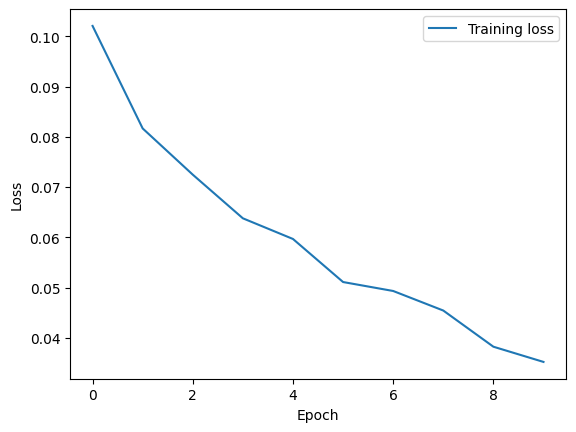

In [79]:
# TRAIN ENTIRE MODEL

# Define the loss function and the optimizer
optimizer_C = optim.Adam(model_C_CNN.parameters(), lr=0.001)
criterion_C = nn.BCEWithLogitsLoss()  # Binary classification for PTB dataset

train_ptb(model_C_CNN,optimizer_C,criterion_C)

Test loss: 0.071.. Test accuracy: 0.980
              precision    recall  f1-score   support

         0.0       0.97      0.95      0.96       809
         1.0       0.98      0.99      0.99      2102

    accuracy                           0.98      2911
   macro avg       0.98      0.97      0.97      2911
weighted avg       0.98      0.98      0.98      2911

F1:  0.9860156435174212


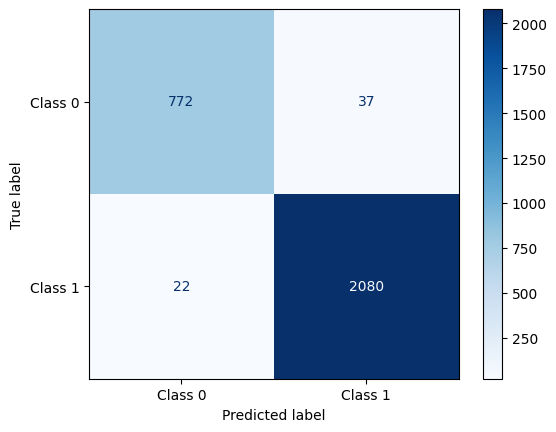

In [80]:
test_loss, accuracy = evaluate_ptb(model_C_CNN, loader_test_ptb, nn.BCEWithLogitsLoss())

In [83]:
save_model = {
    'state_dict': model_C_CNN.state_dict(),
    'optimizer': optimizer_C.state_dict()
}

torch.save(save_model, 'Model_C_CNN.pth')
